In [7]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM
using SSMCMain.ModifiedMiCRM.RandomSystems

In [8]:
using Base.Threads, OhMyThreads
using ProgressMeter
using BenchmarkTools
using JLD2
using Geppetto
using DataFrames
using DataFramesMeta
using HypothesisTests

In [9]:
includet("../../scripts/figures_util.jl")

using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# Setup the functions

## Util

In [4]:
function plot_binom_sample!(ax, xs, ns, num_repeats;
        label="",
        proportions=false,
    )
    if isa(num_repeats, Number)
        num_repeats = fill(num_repeats, length(ns))
    end

    xx = if proportions
        ns ./ num_repeats
    else
        ns
    end
    sl = scatterlines!(ax, xs, xx; label)

    mins = Float64[]
    maxs = Float64[]
    @show proportions
    for (n, nrs) in zip(ns, num_repeats)
        bt = BinomialTest(n, nrs)
        ci = confint(bt; method=:wilson)
        if proportions
            push!(mins, ci[1])
            push!(maxs, ci[2])
        else
            push!(mins, ci[1] * nrs)
            push!(maxs, ci[2] * nrs)
        end
    end

    b = band!(xs, mins, maxs;
        alpha=0.5
    )
    
    (sl, b)
end

plot_binom_sample! (generic function with 1 method)

## Running sims and producing nice dataframes

In [5]:
function do_df_run(Ks, N;
    M=N,
    pei=1.,
    linflux=1.,
    cinflux=1.,
    pe=1.,
    l=0.,
    c=1.,
    num_byproducts=M,
    num_repeats=20,
    lsks=10 .^ range(-5, 3, 2000),
)
    cms = []
    df = DataFrame(;
        K=Float64[],
        sscode=Int[],
        lscode=Union{Missing,Int}[],
        good_ss=Bool[],
        good_ls=Bool[],
        hss_biomass=Float64[],
        k0mrl=Union{Missing,Float64}[],
        maxmrl=Union{Missing,Float64}[],
        params=Any[],
        steadystates=Vector{Float64}[],
    )
    
    @showprogress for K in Ks
        rsg = JansSampler3(N, M;
            K,
            num_influx_resources=1,
    
            # should be a valid non-dim?
            m=1.,
    
            # first network layer
            prob_eating_influx=pei,
            linflux, cinflux,
            
            # rest of the network
            prob_eating=pe,
            l, c,
    
            # rest
            num_byproducts, # applies to both!
    
            Ds=1e-12, Dr=1., Drinflux=1.,
        )
    
        lst = LinstabScanTester2(rsg.Ns + rsg.Nr, lsks;
            # zerothr=1000*eps(),
        )
        params, sss, sscodes, lsrslts = example_do_rg_run3(rsg, num_repeats, lst;
            maxresidthr=1e-8,
            tol=1e-13,
            doextinctls=true,
            maxiters=1e6,
            timelimit=30,
        )
        
        for i in 1:num_repeats
            sscode = sscodes[i]
            good_ss = (sscode in (1, 2))
            lscode = !isnothing(lsrslts[i]) ? lsrslts[i][1] : missing
            good_ls = !ismissing(lscode) ? (lscode in (1, 2)) : true
            push!(df, (
                    K, sscode, lscode, good_ss, good_ls,
                    sum(sss[i][1:N]),
                    !ismissing(lscode) ? lsrslts[i][2] : missing,
                    !ismissing(lscode) ? lsrslts[i][3] : missing,
                    params[i], sss[i]
            ))
        end
    
        codes = Int[]
        for i in 1:num_repeats
            if sscodes[i] == 1
                push!(codes, lsrslts[i][1])
            elseif sscodes[i] == 2
                push!(codes, 101)
            else
                push!(codes, sscodes[i])
            end
        end
        
        cm = countmap(codes)
        push!(cms, cm)
    end
    
    @show countmap(df.sscode) countmap(df.lscode) count(df.good_ss .&& df.good_ls) / nrow(df)
    kk = count(df.good_ss .&& df.good_ls) / nrow(df)
    @show kk

    df, cms
end
function do_df_run2(Ks, N, B; M=N, kwargs...)
    pe = B / M
    do_df_run(Ks, N;
        M,
        pei=pe,
        pe,
        num_byproducts=B,
        kwargs...
    )
end

do_df_run2 (generic function with 1 method)

In [6]:
function make_counts_df(df)
    probsdf = DataFrame(;
        K=Float64[],
        num_runs=Int[],
        bad_ss=Int[],
        extinct=Int[],
        good_ss_bad_ls=Int[],
        nonext_stable=Int[],
        nonext_unstable=Int[],
    )
    for x in groupby(df, :K)
        K = x.K[1]
        num_runs = nrow(x)
        
        bad_ss = 0
        extinct = 0
        good_ss_bad_ls = 0
        nonext_stable = 0
        nonext_unstable = 0
        for r in eachrow(x)
            if r.sscode == 1
                if r.lscode == 1
                    nonext_stable += 1
                elseif r.lscode == 2
                    nonext_unstable += 1
                else
                    good_ss_bad_ls += 1
                end
            elseif r.sscode == 2
                extinct += 1
            else
                bad_ss += 1
            end
        end
        push!(probsdf, (
            K, num_runs,
            bad_ss,
            extinct,
            good_ss_bad_ls,
            nonext_stable,
            nonext_unstable,
        ))
    end

    probsdf
end

make_counts_df (generic function with 1 method)

## Plotting the dataframes

In [9]:
function plot_cdf1!(ax, cdf; include_bad=true, proportions=false)
    goodruns = cdf.num_runs .- cdf.bad_ss .- cdf.good_ss_bad_ls
    p1 = plot_binom_sample!(ax, cdf.K, cdf.extinct, goodruns;
        label="extinct",
        proportions
    )
    # lsruns = cdf.num_runs .- cdf.bad_ss .- cdf.extinct
    p2 = plot_binom_sample!(ax, cdf.K, cdf.nonext_unstable, goodruns;
        label="unstable",
        proportions
    )
    p3 = plot_binom_sample!(ax, cdf.K, cdf.nonext_stable, goodruns;
        label="stable",
        proportions
    )
    if include_bad
        p3 = plot_binom_sample!(ax, cdf.K, cdf.bad_ss .+ cdf.good_ss_bad_ls, cdf.num_runs;
            label="bad data",
            proportions
        )
    end
    (p1, p2, p3)
end
function plot_cdf1(cdf; kwargs...)
    f = Figure()
    ax = Axis(f[1,1];
        xlabel="K",
        xscale=log10,
    )
    p = plot_cdf1!(ax, cdf; kwargs...)
    axislegend(ax)
    FigureAxisAnything(f, ax, p)
end

plot_cdf1 (generic function with 1 method)

In [10]:
function plot_df1(df)
    f = Figure(;
        # size=(800, 500)
    )
    
    ax_biom = Axis(f[1,1:2];
        ylabel="HSS biomass",
        yscale=Makie.pseudolog10,
        # yscale=Makie.log10,
        xscale=log10,
    )
    ax2 = Axis(f[2,:];
        ylabel="observed MRL",
        xscale=log10,
    )
    ax3 = Axis(f[3,:];
        ylabel="MRL at K=0",
        xscale=log10,
    )
    ax4 = Axis(f[4,1];
        ylabel="Counts",
        xscale=log10,
    )
    linkxaxes!(ax_biom, ax4)
    linkxaxes!(ax2, ax4)
    linkxaxes!(ax2, ax4)
    for ax in [ax_biom, ax2, ax3]
        hidexdecorations!(ax;
            grid=false,
            ticks=false,
        )
    end
    ax4.xlabel = "K"
    
    xx = @subset df :good_ss
    # scatter!(ax_biom, xx.K, clamp.(xx.hss_biomass, 1e-20, Inf))
    scatter!(ax_biom, xx.K, xx.hss_biomass)
    
    scatter!(ax2, xx.K, xx.maxmrl)
    maxmaxmrl = maximum(xx.maxmrl)
    ylims!(ax2, (-1.1, 1.1) .* abs(maxmaxmrl))
    text!(ax2, 0.05, 0.75;
        text=(@sprintf "max is %.5g" maxmaxmrl),
        space=:relative,
    )
    
    scatter!(ax3, xx.K, xx.k0mrl)
    maxk0mrl = maximum(xx.k0mrl)
    ylims!(ax3, (-1.1, 1.1) .* abs(maxk0mrl))
    text!(ax3, 0.05, 0.75;
        text=(@sprintf "max is %.5g" maxk0mrl),
        space=:relative,
    )
    
    # display(GLMakie.Screen(), f)
    
    rowgap!(f.layout, 1.)
    plot_cdf1!(ax4, make_counts_df(df))
    # axislegend(ax4; position=:lc)
    Legend(f[4,2], ax4; padding=0.)

    f
end

plot_df1 (generic function with 1 method)

# Figure 1b v1

## Generate data

In [9]:
function gendata1(fname=joinpath("./figures_data/", "f1b_gd1_"*timestamp()*".jld2"))
    N = 10
    M = N
    B = 3
    
    lis = 1.:-0.02:0.8
    # lis = [1., 0.99, 0.9, 0.8]
    # lis = [1.]
    Ks = 10 .^ range(-0.5, 4., 20)
    
    raw_dfs = []
    counts_dfs = []
    for li in lis
        @show li
        flush(stdout)
        df, cms = do_df_run(Ks, N;
            M,
            
            pei=1.,
            linflux=li,
            cinflux=1.,
            
            pe=(B / M),
            l=0.,
            c=1.,
            
            num_byproducts=B,
            
            num_repeats=50,
            lsks=10 .^ range(-5, 3, 2000),
        );
        push!(raw_dfs, df)
        push!(counts_dfs, make_counts_df(df))
    end
    
    jldsave(fname;
        N, M, B, lis, Ks, raw_dfs, counts_dfs
    )

    fname
end

gendata1 (generic function with 2 methods)

In [147]:
# Started at 15:32

In [146]:
xx = gendata1()

li = 1.0


Progress:  60%|████████████████████████▋                |  ETA: 0:00:27┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 1.81903 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:26┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 29.2562 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrob

countmap(df.sscode) = Dict(2 => 300, -2000 => 3, 1 => 697)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 8, 23 => 1, 13 => 3, 2 => 409, 11 => 4, 12 => 61, 1 => 511, missing => 3)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.92
kk = 0.92
li = 0.98


Progress:  35%|██████████████▍                          |  ETA: 0:00:34┌ Warning: At t=381.7328952270191, dt was forced below floating point epsilon 5.684341886080802e-14, and step error estimate = 0.00024327542843244264. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623
┌ Error: maxresid reached is 9.60302e+24 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  40%|████████████████▍                        |  ETA: 0:00:35┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff 

countmap(df.sscode) = Dict(2 => 294, -2000 => 3, 1 => 703)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 7, 23 => 8, 13 => 3, 2 => 197, 11 => 28, 12 => 22, 1 => 732, missing => 3)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.929
kk = 0.929
li = 0.96


Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:23┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:06┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
Progress: 100%|█████████████████

countmap(df.sscode) = Dict(2 => 294, -1004 => 2, 1 => 704)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 2, 13 => 6, missing => 2, 2 => 126, 11 => 42, 12 => 20, 1 => 797, 23 => 5)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.923
kk = 0.923
li = 0.94


Progress:  55%|██████████████████████▌                  |  ETA: 0:00:30┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 2.76153 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:27┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src

countmap(df.sscode) = Dict(2 => 283, -2000 => 1, -1004 => 1, 1 => 715)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 8, 13 => 3, missing => 2, 2 => 114, 11 => 39, 12 => 14, 1 => 818, 23 => 2)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.932
kk = 0.932
li = 0.92


Progress:  40%|████████████████▍                        |  ETA: 0:00:30┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
Progress: 100%|█████████████████████████████████████████| Time: 0:02:50


countmap(df.sscode) = Dict(2 => 280, -1004 => 1, 1 => 719)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(missing => 1, 13 => 8, 2 => 77, 11 => 39, 12 => 18, 1 => 843, 23 => 14)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.92
kk = 0.92
li = 0.9


Progress:  50%|████████████████████▌                    |  ETA: 0:00:33┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: maxresid reached is 0.00217768 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
Progress: 100%|█████████████████████████████████████████| Time: 0:02:17


countmap(df.sscode) = Dict(2 => 279, 1 => 720, 1004 => 1)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 3, missing => 1, 13 => 7, 2 => 74, 11 => 45, 12 => 12, 1 => 854, 23 => 4)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.928
kk = 0.928
li = 0.88


Progress:  30%|████████████▎                            |  ETA: 0:00:27┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 0.0189999 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  60%|████████████████████████▋                |  ETA: 0:00:47┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 1.50487 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicr

countmap(df.sscode) = Dict(2 => 272, -2000 => 2, -1004 => 1, 1 => 725)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(missing => 3, 13 => 2, 2 => 35, 11 => 55, 12 => 4, 1 => 896, 23 => 5)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.931
kk = 0.931
li = 0.86


Progress: 100%|█████████████████████████████████████████| Time: 0:02:12


countmap(df.sscode) = Dict(2 => 261, 1 => 739)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 1, 13 => 5, 2 => 41, 11 => 49, 12 => 13, 1 => 887, 23 => 4)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.928
kk = 0.928
li = 0.84


Progress:  30%|████████████▎                            |  ETA: 0:00:29┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Error: maxresid reached is 0.274424 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  35%|██████████████▍                          |  ETA: 0:01:22┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method fo

countmap(df.sscode) = Dict(2 => 263, -2000 => 1, -1004 => 1, 1 => 733, 1004 => 2)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(missing => 4, 13 => 5, 22 => 2, 2 => 39, 11 => 60, 12 => 9, 1 => 873, 23 => 8)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.912
kk = 0.912
li = 0.82


Progress:  25%|██████████▎                              |  ETA: 0:00:26┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 0.0124502 which is above the error threshold of 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:400
Progress:  35%|██████████████▍                          |  ETA: 0:01:29┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/s

countmap(df.sscode) = Dict(2 => 259, -2000 => 5, -1004 => 1, 1 => 735)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(23 => 6, 13 => 7, 22 => 1, 2 => 46, 11 => 45, 12 => 9, 1 => 880, missing => 6)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.926
kk = 0.926
li = 0.8


Progress:  30%|████████████▎                            |  ETA: 0:00:28┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: maxresid reached is 3.81967e-07 > 1e-08
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:403
┌ Warning: Solver quit due to time limit being reached
└ @ SSMCMain.ModifiedMiCRM.RandomSystems ~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/RandomSystems.jl:393
┌ Error: maxresid reached is 0.0342176 which is above the error threshol

countmap(df.sscode) = Dict(2 => 251, -2000 => 1, 1 => 747, 1004 => 1)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(22 => 2, missing => 2, 13 => 5, 2 => 57, 11 => 56, 12 => 6, 1 => 864, 23 => 8)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.921
kk = 0.921


"./figures_data/f1b_gd1_251006_153153.jld2"

### Extracting boundaries

In [127]:
function boundaries_from_f(f)
    lis = f["lis"]

    b1s = []
    b2s = []
    
    for i in 1:length(lis)
        cdf = f["counts_dfs"][i]

        found_b1 = false
        found_b2 = false
        for r in eachrow(cdf)
            if (!found_b1) && (r.extinct < (r.nonext_unstable + r.nonext_stable))
                push!(b1s, r.K)
                found_b1 = true
            end
            if (!found_b2) && (r.nonext_stable > (r.nonext_unstable + r.extinct))
                push!(b2s, r.K)
                found_b2 = true
            end
            if found_b1 && found_b2
                break
            end
        end
    end

    lis, b1s, b2s
end

boundaries_from_f (generic function with 1 method)

## Boundaries plot

In [11]:
f = jldopen("figures_data/f1b_gd1_251006_153153.jld2")
lis, b1s, b2s = boundaries_from_f(f)

LoadError: UndefVarError: `boundaries_from_f` not defined

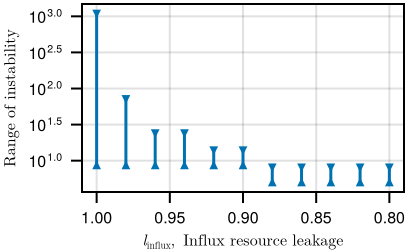

In [162]:
fig = Figure(;
    size=(double_col_width * 0.3, (double_col_width / golden_ratio) * 0.3),
    default_fig_kwargs...,
)

ax = Axis(fig[1,1];
    xlabel=L"l_\text{influx},\enspace\text{Influx resource leakage}",
    ylabel=L"\text{Range of instability}",
    yscale=log10,
    xreversed=true,
)

rangebars!(ax, lis, b1s, b2s;
    color=Cycled(1)
)
scatter!(ax, lis, b1s;
    color=Cycled(1),
    marker=:utriangle
)
scatter!(ax, lis, b2s;
    color=Cycled(1),
    marker=:dtriangle
)

Makie.save("../../figures/fig1/boundaries.pdf", fig)

fig

## l_i=1 only including biomass

In [58]:
f = jldopen("figures_data/f1b_gd1_251006_131925.jld2")
ii = findfirst(x->x==1., f["lis"])
if isnothing(ii)
    @error "This data file does not contain a li = 1 run"
end
@show ii
f

ii = 1


JLDFile /home/honza/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/notebooks/clean slate/figures_data/f1b_gd1_251006_131925.jld2 (read-only)
 ├─🔢 N
 ├─🔢 M
 ├─🔢 B
 ├─🔢 lis
 ├─🔢 Ks
 ├─🔢 raw_dfs
 └─🔢 counts_dfs

In [59]:
Ks = f["Ks"]
li = f["lis"][ii]
df = f["raw_dfs"][ii];
counts_df = f["counts_dfs"][ii];

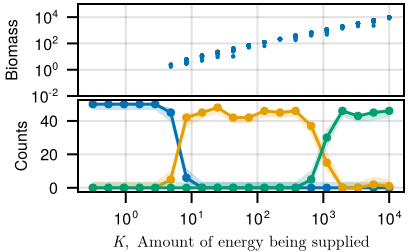

In [108]:
function biomass_prop_plot1(f, i)
    Ks = f["Ks"]
    li = f["lis"][i]
    df = f["raw_dfs"][i]
    counts_df = f["counts_dfs"][i]
    
    fig = Figure(;
        size=(double_col_width * 0.3, (double_col_width / golden_ratio) * 0.3),
        default_fig_kwargs...,
        # figure_padding=(2., 2., 2., 2.)
    )

    bm_yy = [-2, 0, 2, 4]
    bm_ax = Axis(fig[1,1];
        xscale=log10,
        yscale=log10,
        yticks=(10. .^ bm_yy, [rich("10", superscript(string(e))) for e in bm_yy]),
        ylabel="Biomass"
    )
    props_ax = Axis(fig[2,1];
        xscale=log10,
        xlabel=L"K,\enspace\text{Amount of energy being supplied}",
        ylabel="Counts"
    )
    linkxaxes!(bm_ax, props_ax)
    hidexdecorations!(bm_ax; grid=false)

    rowgap!(fig.layout, 2.)
    
    hbs = df.hss_biomass
    hbs = clamp.(hbs, minimum(abs, hbs), Inf)
    scatter!(bm_ax, df.K, hbs;
        markersize=3,
    )
    ylims!(bm_ax, 1e-2, 1e5)
    
    plot_cdf1!(props_ax, counts_df; include_bad=false)
    
    fig
end
fig = biomass_prop_plot1(f, ii)
Makie.save("../../figures/fig1/li1_props_and_biomass.pdf", fig)

fig

## Plot for Steven

In [29]:
f = jldopen("figures_data/f1b_gd1_251006_153153.jld2")

Ks = f["Ks"]
lis = f["lis"]
cdfs = f["counts_dfs"];

In [52]:
lis[4]

0.94

proportions = true
proportions = true
proportions = true


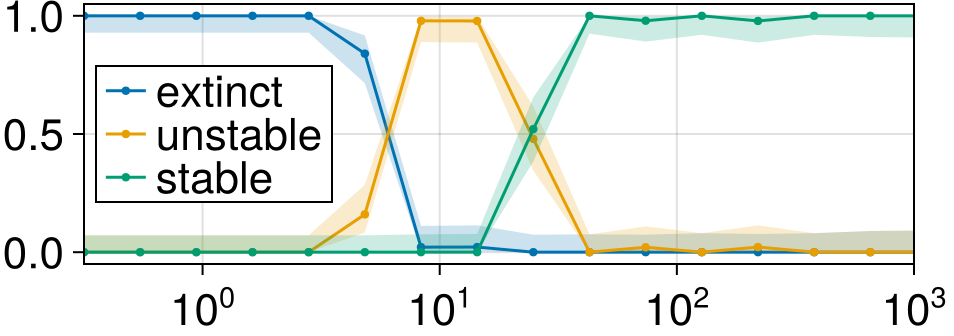

In [91]:
fig = Figure(;
    size=(double_col_width * 0.7, (double_col_width / golden_ratio) * 0.4),
    default_fig_kwargs...,
    fontsize=22,
    figure_padding=(2., 20., 2., 2.)
)
ax = Axis(fig[1,1];
    xscale=log10,
    # xlabel=L""
)

plot_cdf1!(ax, cdfs[3];
    include_bad=false,
    proportions=true
)
xlims!(ax, 10 .^ -0.5, 10 .^ 3)
axislegend(ax;
    position=:lc,
    rowgap=-4.,
    padding=(5., 5., 0., 0.)
)
ax.xticks = (10 .^ (0:3), [rich("10", superscript(string(e))) for e in 0:3])

Makie.save("../../figures/forsteven/f1.pdf", fig)

fig

## Stacked prop plots

In [20]:
f = jldopen("figures_data/f1b_gd1_251006_153153.jld2")

JLDFile /home/honza/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/notebooks/clean slate/figures_data/f1b_gd1_251006_153153.jld2 (read-only)
 ├─🔢 N
 ├─🔢 M
 ├─🔢 B
 ├─🔢 lis
 ├─🔢 Ks
 ├─🔢 raw_dfs
 └─🔢 counts_dfs

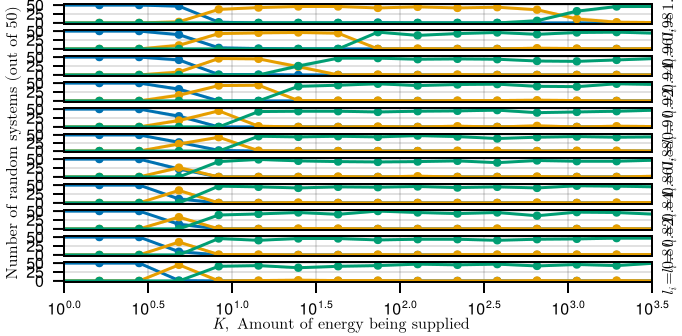

In [21]:
fig = Figure(;
    size=(double_col_width * 0.5, (double_col_width / golden_ratio) * 0.4),
    default_fig_kwargs...
)

Ks = f["Ks"]
lis = f["lis"]
cdfs = f["counts_dfs"]

num_ls = length(lis)

axs = []
for i in 1:num_ls
    ax = Axis(fig[i,2];
        xscale=log10
    )

    Label(fig[i,3], latexstring("l_i = $(lis[i])"); rotation=pi/2, tellheight=false)

    plot_cdf1!(ax, cdfs[i]; include_bad=false)

    xlims!(ax, 10^0, 10^3.5)
    ylims!(ax, -3, 53)

    ax.yticks = [0, 25, 50]
    # ax.yticks = 0:10:50

    push!(axs, ax)
end

for i in 2:num_ls
    linkxaxes!(axs[1], axs[i])
end
for i in 1:(num_ls-1)
    hidexdecorations!(axs[i];
        # ticks=false,
        grid=false
    )
end

Label(fig[:,1], L"\text{Number of random systems (out of 50)}"; rotation=pi/2)
Label(fig[num_ls+1,:], L"K,\enspace\text{Amount of energy being supplied}")

colgap!(fig.layout, 4)
rowgap!(fig.layout, 3.)
rowgap!(fig.layout, num_ls, 0.)

lfig = Figure(;
    size=(20, 16) .* pt_per_mm_ratio,
    default_fig_kwargs...,
    fontsize=10
)
Legend(lfig[1,1], axs[1];
    rowgap=-8.,
    padding=(5., 5., 0., 0.)
)
lfig

# Makie.save("../../figures/fig1/panel_b.pdf", fig)
# Makie.save("../../figures/fig1/legend.pdf", lfig)

fig

# Playing around

In [15]:
N = 10
M = N
B = 3

df, cms = do_df_run(10 .^ range(0., 3., 5), N;
    M,
    
    pei=1.,
    linflux=1.,
    cinflux=1.,
    
    pe=(B / M),
    l=0.,
    c=1.,
    
    num_byproducts=B,
    
    num_repeats=20,
    lsks=10 .^ range(-5, 3, 2000),
);
csdf = make_counts_df(df);

Progress:  60%|████████████████████████▋                |  ETA: 0:00:03┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


countmap(df.sscode) = Dict(2 => 28, -1004 => 1, 1 => 71)
countmap(df.lscode) = Dict{Union{Missing, Int64}, Int64}(2 => 54, 12 => 3, 1 => 42, missing => 1)
count($(Expr(:.&&, :(df.good_ss), :(df.good_ls)))) / nrow(df) = 0.96
kk = 0.96


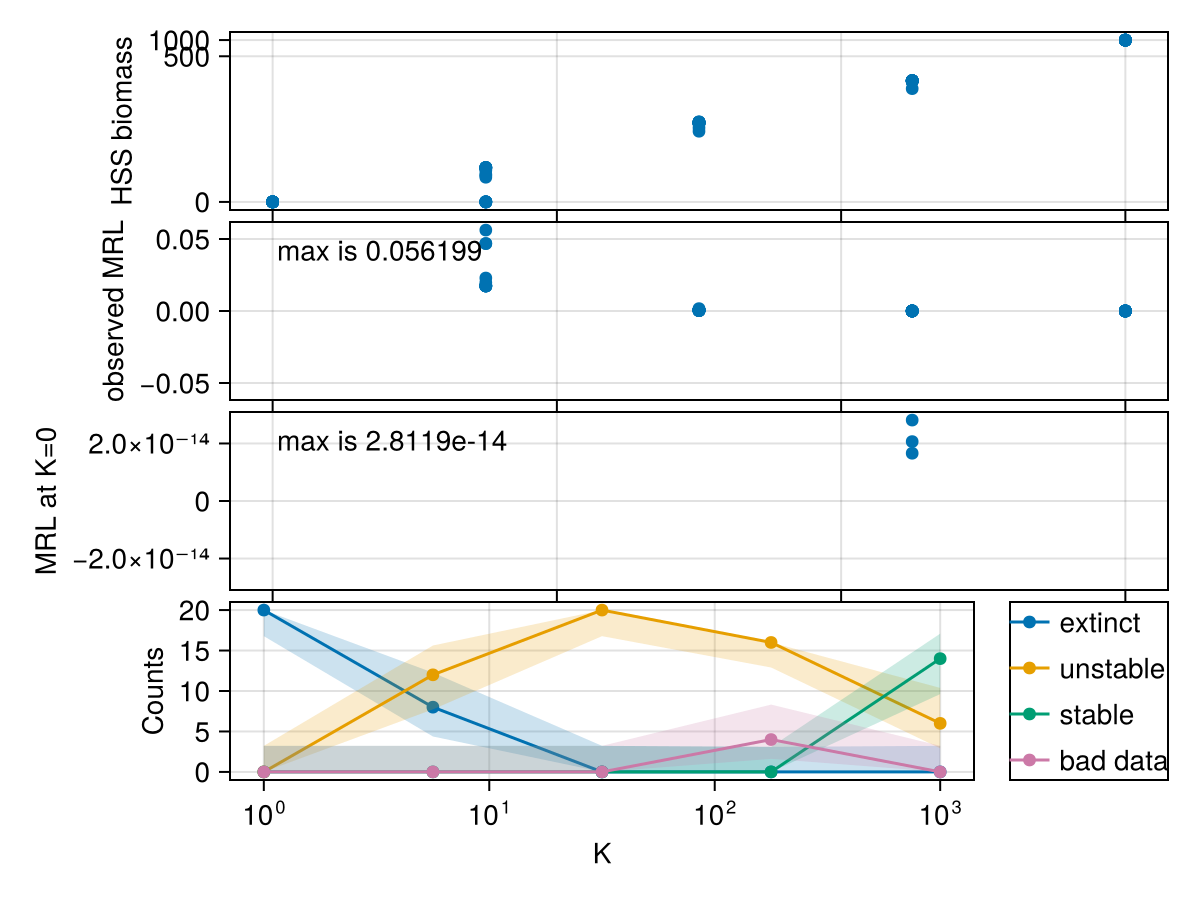

In [16]:
plot_df1(df)

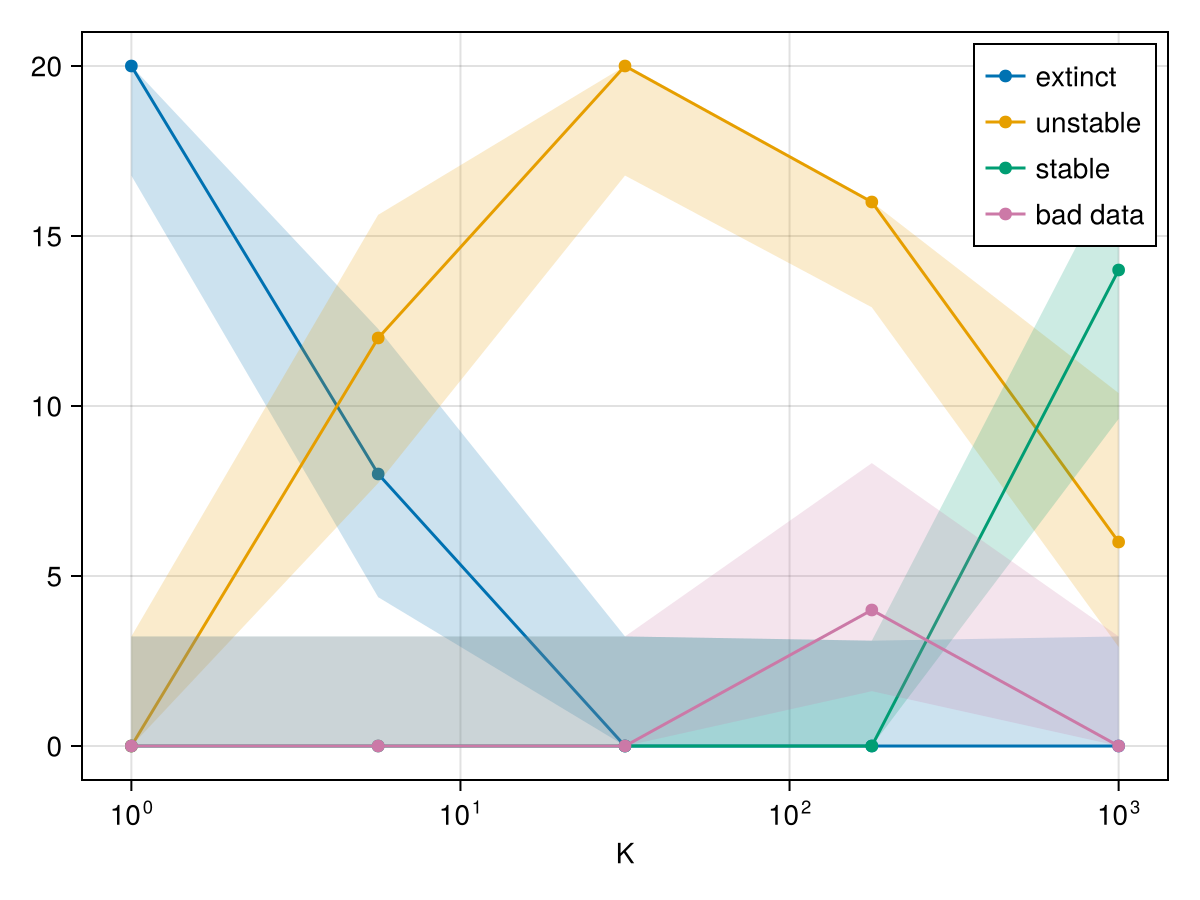

In [18]:
plot_cdf1(csdf)

# Testing a particular system

In [108]:
ps = rsg();
# ps = ms();

LoadError: UndefVarError: `rsg` not defined

In [162]:
# i = rand(findall((df.sscode .== 1) .&& isapprox.(df.K, 1.5; atol=0.1)))
# i = rand(findall(df.lscode .=== 2)) # unstable system
# i = rand(findall((df.lscode .=== 1) .&& (df.sscode .== 1))) # nonext stable system
# i = rand(findall(df.sscode .== -2000))
i = rand(findall(df.sssurvivors .== 7))
dfr = df[i,:]
ps = dfr.params;
dfr

Row,K,sscode,lscode,good_ss,good_ls,hss_biomass,k0mrl,maxmrl,params,steadystates,sssurvivors
,Float64,Int64,Int64?,Bool,Bool,Float64,Float64?,Float64?,Any,Array…,Int64
242,125.893,1,22,true,false,113.553,3.31449e-13,7.03181e-5,"BSMMiCRMParams{Nothing, Nothing, Nothing, Float64}(BMMiCRMParams{Nothing, Float64}([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 125.893, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 0.0;;; 1.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], nothing), [1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0e-12, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], nothing, nothing)","[1.0842e-13, 6.58874, 1.0842e-13, 12.9004, 6.58874, 1.0842e-13, 24.3867, 12.9004, 25.8008, 24.3867, 4.545e-12, 1.0, 1.09899, 1.0, 0.0, 0.0, 1.0, 1.0, 7.24098, 0.0]",7


## No space solver

  0.001348 seconds (428 allocations: 80.594 KiB)
sort((s.u[end])[1:N]; rev = true) = [25.859509414993166, 24.46099630137437, 24.459801805622142, 13.097425681099269, 12.76077211234309, 6.506012382824172, 6.506012085484335, 4.9819320590046306e-30, 2.8927995888216e-63, -8.365055911323962e-161]


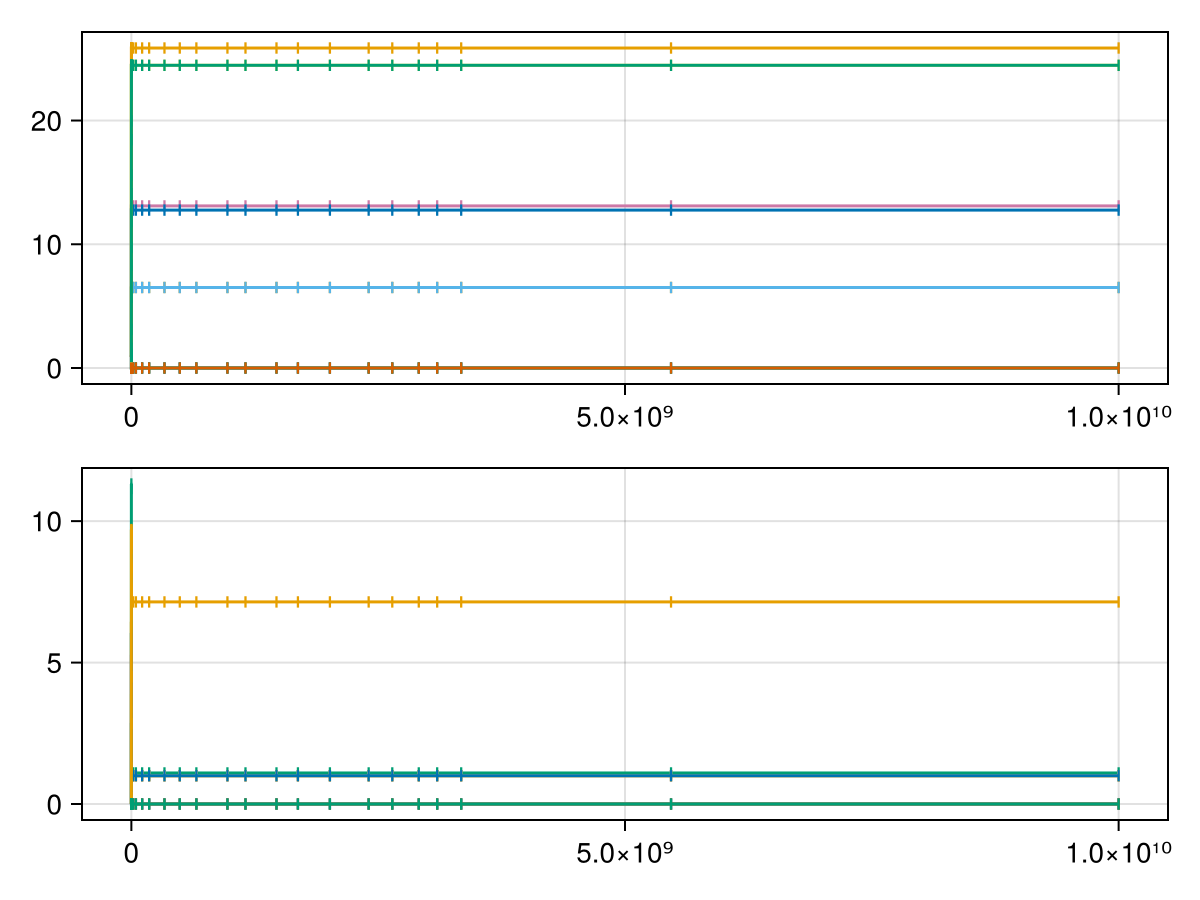

In [163]:
# Fixed time with evolution
u0 = make_u0_smart(ps; u0=:onlyN);
p = make_mmicrm_problem(ps, u0, 10000000000);
# p = remake_guarantee_positive(p)

@time s = solve(p, TRBDF2();
    callback=make_timer_callback(1.)
)

@show sort(s.u[end][1:N]; rev=true)

f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
f

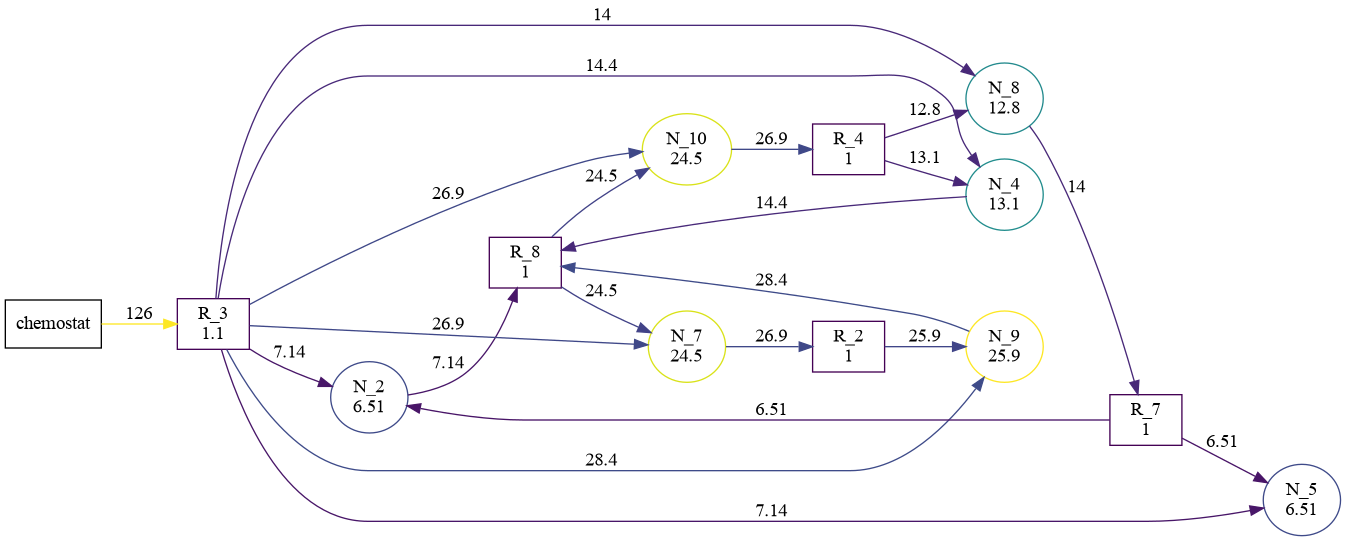

In [164]:
diagram_sfss_v3(ps, clamp.(s.u[end], minimum(abs, s.u[end]), Inf);
    strain_threshold=1e-3,
    # colorscale=log10,
)

In [149]:
# Steady state
u0 = make_u0_smart(ps; u0=:onlyN)
ssp = make_mmicrm_ss_problem(ps, u0)
@time sss = solve(ssp, DynamicSS(QNDF());
    abstol=eps(),
    reltol=eps(),
    callback=make_timer_callback(10),
);
maximum(abs, sss.resid)

 14.477851 seconds (9.27 M allocations: 811.985 MiB, 25.07% gc time, 42.08% compilation time)


1.6579350071639944e-12

## Spatial stuff

In [118]:
nssol = s.u[end];
# nssol = sss.u
xx = uninplace(mmicrmfunc!)(nssol, ps)
maxresid = maximum(abs, xx)
@show maxresid;

maxresid = 2.2737367544323206e-13


### Linear stability

In [380]:
# ks = LinRange(0., 50., 10000)
# ks = lsks
ks = 10 .^ range(-5, 5, 2000)

Ds = get_Ds(ps)
# Ds = vcat(
#     fill(1e-8, get_Ns(ps)[1]),
#     fill(1e-8, get_Ns(ps)[2])
# )
# Ds[20] = 10000

lamfunc = linstab_make_k_func(ps, Ds, nssol)
lambdas = lamfunc.(ks);

maximum(x->maximum(real, x), lambdas)

0.0001301885064772557

In [381]:
xx = LinstabScanTester2(ps, 50., 1000)
xx(ps, nssol)

(2, -0.02617729569943119, 0.0001290439236254262, true)

[ Info: Unstable, mrl is 0.000130189


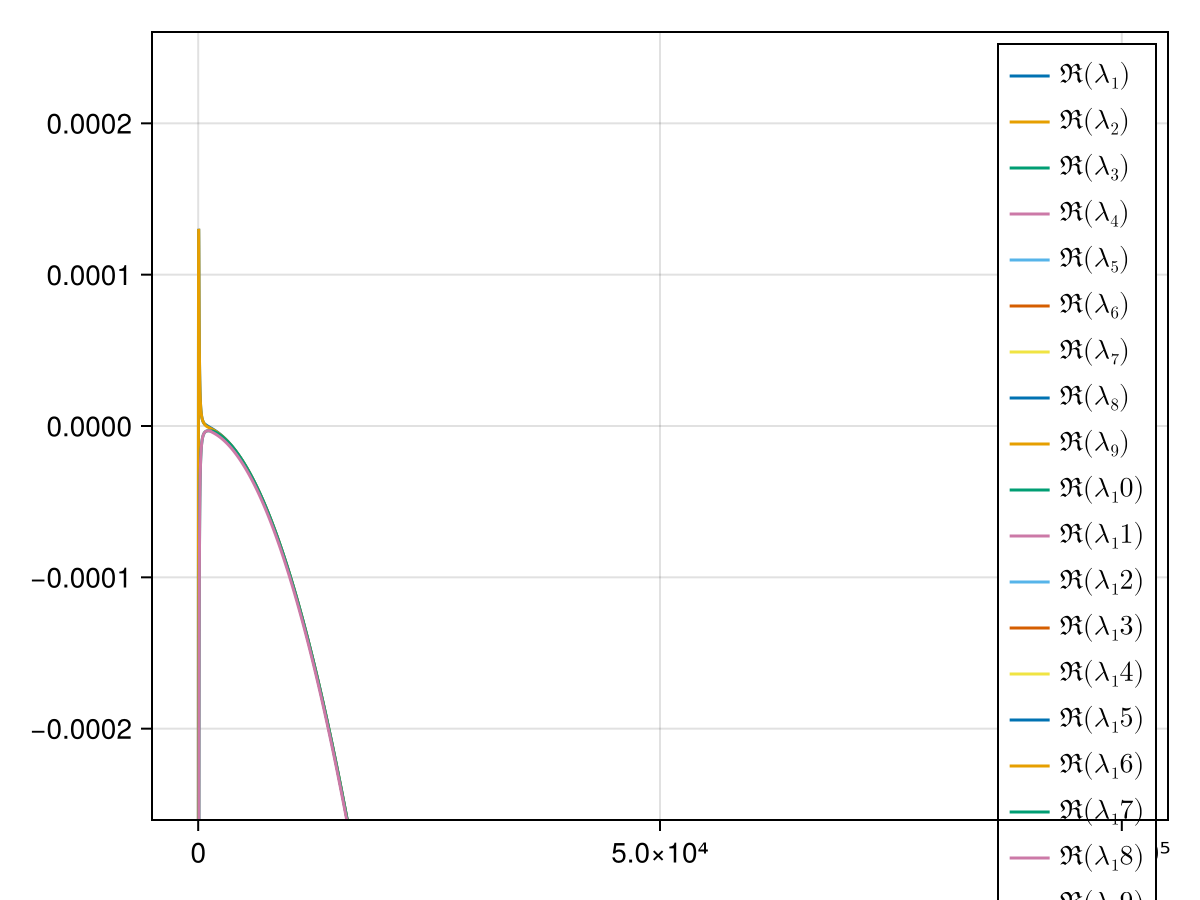

In [382]:
faa = plot_linstab_lambdas(ks, lambdas;
    imthreshold=Inf
)
# display(GLMakie.Screen(), faa.figure)
kk = abs(maximum(x->maximum(real, x), lambdas))
ylims!(faa.axis, (-2., 2.) .* kk)
# xlims!(faa.axis, 0., 1000)
faa

### 1D spatial

In [349]:
ssize = (1000,)
dx = 0.01

# baseu0 = nssol
baseu0 = make_u0_smart(ps; u0=:onlyN)
su0 = expand_u0_to_size(ssize, baseu0)
su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)


spaceps = change_bsmmicrmparams(ps; space=make_cartesianspace_smart(1;
    dx,
    bcs=Periodic()),
    usenthreads=nthreads()
)
@show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

sp = make_smmicrm_problem(spaceps, su0, 100000);

spaceps.usenthreads = 18
spaceps.mmicrm_params.usenthreads = nothing


In [350]:
@time sps = solve(sp, QNDF());
print_spatial_solution_stats(sps)

  9.385754 seconds (13.18 M allocations: 3.611 GiB, 2.23% gc time, 129.82% compilation time)
Success
nf is 1030
solution has 155 saved states
max resid is 2.55048e-06


┌ Warning: reaching negative values, minimum is -3.34381e-07
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


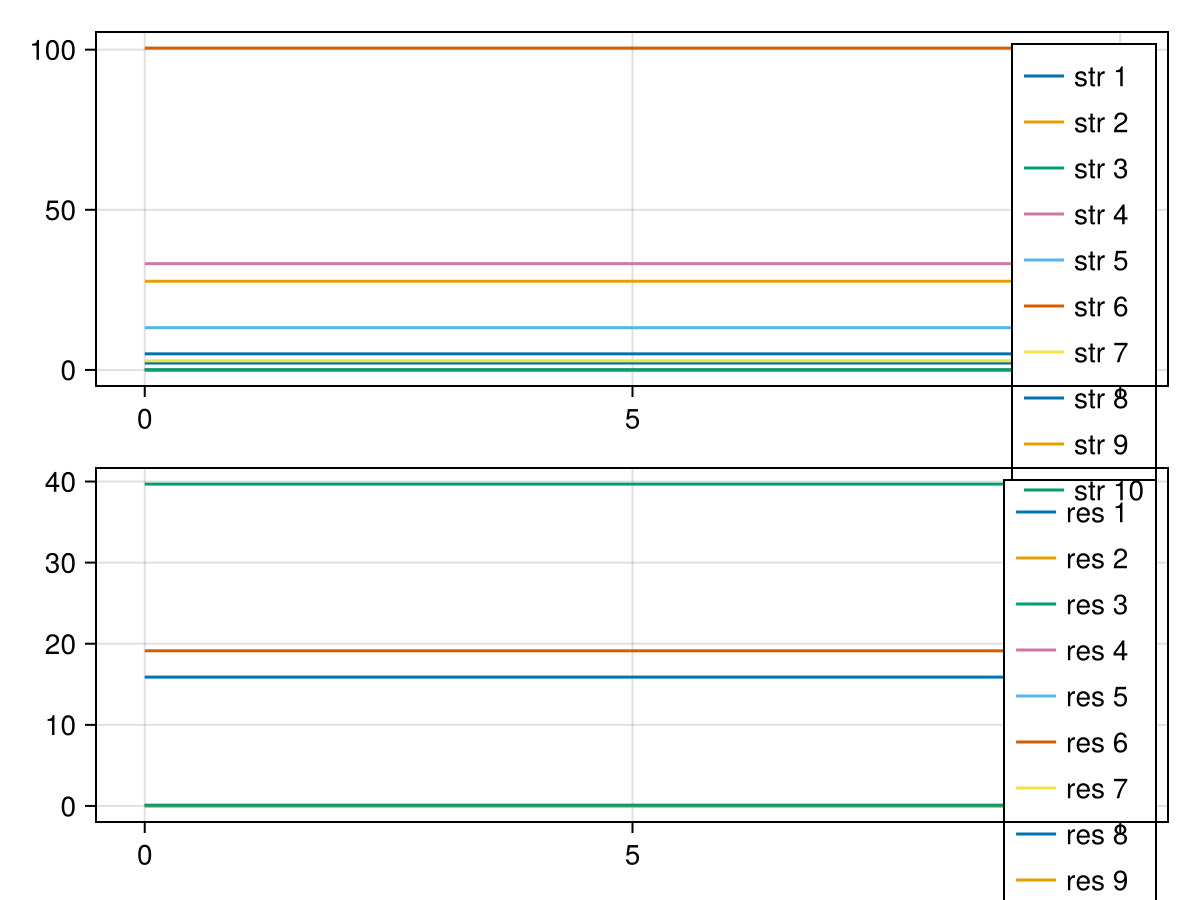

In [352]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

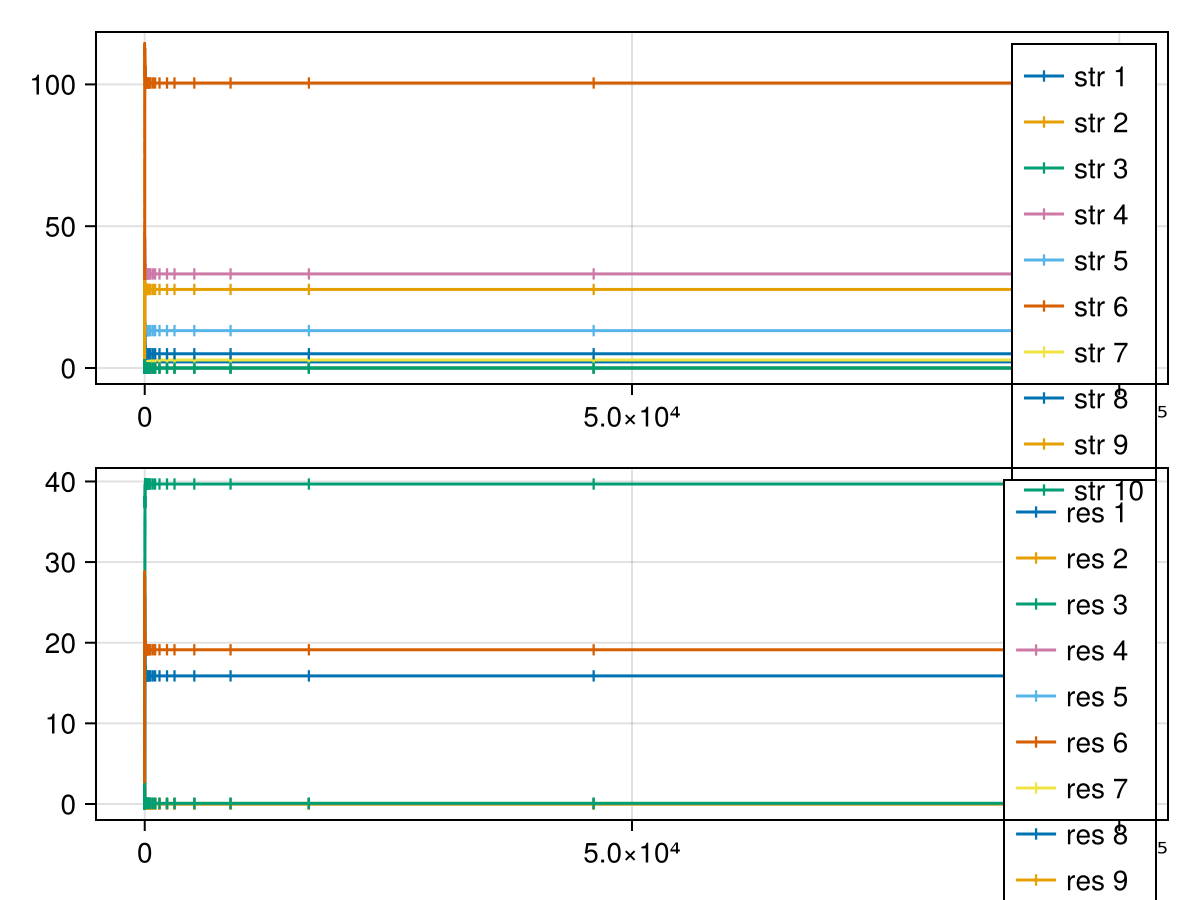

In [353]:
plot_smmicrm_sol_avgs(sps)

# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()